## Khởi tạo

In [2]:
import numpy as np
import cv2
import pytesseract
import easyocr
from myutils import MyUtils
from mynbutils import show_cv2_img
from ndbsx_v1 import NDBSXv1

# Nếu dùng Windows, cần chỉ rõ đường dẫn Tesseract
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

reader = easyocr.Reader(['en']) # this needs to run only once to load the model into memory

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


In [3]:
# tính độ nghiêng: đầu vào phải là ảnh gray
# độ chính xác thấp, cần làm lại
def cal_angle(img):
  blur = cv2.GaussianBlur(img, (5, 5), 0)
  edges = cv2.Canny(blur, 50, 150)

  # Tìm contour
  contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

  # Lọc contour lớn nhất (giả sử là biển số)
  max_contour = max(contours, key=cv2.contourArea)

  # Tính hình chữ nhật xoay nhỏ nhất
  rect = cv2.minAreaRect(max_contour)
  (box_x, box_y), (w, h), angle = rect

  # Hiển thị thông tin
  print(f"Độ nghiêng (góc): {angle:.2f} độ")

  # Vẽ rectangle để kiểm tra
  box = cv2.boxPoints(rect)
  box = np.intp(box)
  img_box_bgr = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
  img_box = cv2.drawContours(img_box_bgr, [box], 0, (0, 255, 0), 2)

  show_cv2_img(img_box)

  return angle

In [3]:
ndbsx = NDBSXv1()

Using cache found in C:\Users\DELL/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2025-5-19 Python-3.12.8 torch-2.2.2+cpu CPU

Fusing layers... 
Model summary: 213 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


## Tìm vị trí biển số xe

In [4]:
%matplotlib inline
# Load 1 file ảnh ngẫu nhiên
bsx_path = './data/bsx/'
img_bgr = MyUtils.load_random_image(bsx_path)

# xác định vị trí bsx
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
detections = ndbsx.find_bsx_rect(img_rgb)

#### Debug: vị trí biến số xe

In [104]:
# hiện ảnh vị trí biển số xe
def debug_crop_bsx():
    for d in detections:
        x1, y1, x2, y2 = d["box"]
        x1, y1, x2, y2 = map(int, [x1, y1, x2, y2])
        label = f"{d["conf"]:.2f}"
        
        # Draw bounding box
        cv2.rectangle(img_bgr, (x1, y1), (x2, y2), color=(0, 255, 0), thickness=2)
        # Put label above the box
        cv2.putText(img_bgr, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX,
                    fontScale=0.5, color=(0, 255, 0), thickness=2)

    show_cv2_img(img_bgr)

### Xử lý ảnh

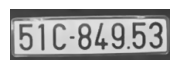

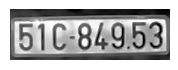

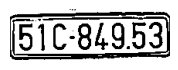

In [ ]:
lp_bgr = MyUtils.crop_bsx(img_bgr, detections[0], 3)
lp_gray = cv2.cvtColor(lp_bgr, cv2.COLOR_BGR2GRAY)
lp_gray = cv2.bilateralFilter(lp_gray, 11, 17, 17)  # làm mịn

show_cv2_img(lp_gray)

lp_contrast = cv2.equalizeHist(lp_gray)
show_cv2_img(lp_contrast)

# Áp dụng adaptive thresholding
lp_thresh = cv2.adaptiveThreshold(lp_gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
show_cv2_img(lp_thresh)

# Áp dụng Otsu thresholding
# _, lp_thresh = cv2.threshold(lp_gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
# show_cv2_img(lp_thresh)

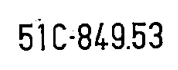

In [17]:
# Xóa viền
lp_bi_1 = MyUtils.tach_vien(lp_thresh)
show_cv2_img(lp_bi_1)

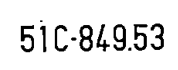

In [18]:
# xóa bọt
def xoa_bot(image_bi, sz = 2):
  # Tạo kernel cho phép toán hình thái
  kernel = np.ones((sz, sz), np.uint8)  # Kích thước kernel có thể điều chỉnh (3x3 hoặc 5x5)

  # Áp dụng phép toán mở (opening) để loại bỏ nhiễu trắng nhỏ
  cleaned = cv2.morphologyEx(image_bi, cv2.MORPH_OPEN, kernel, iterations=1)

  # (Tùy chọn) Áp dụng phép toán đóng (closing) để lấp các lỗ nhỏ trong văn bản
  cleaned = cv2.morphologyEx(cleaned, cv2.MORPH_CLOSE, kernel, iterations=1)

  return cleaned

lp_bi_2 = xoa_bot(lp_bi_1)
show_cv2_img(lp_bi_2)

#### Tính góc nghiêng

Độ nghiêng (góc): 90.00 độ


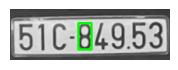

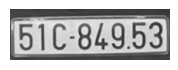

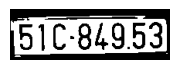

In [46]:
angle = cal_angle(lp_gray)

lp_gray_rotated = MyUtils.rotate_image(lp_gray, angle - 90)
show_cv2_img(lp_gray_rotated)

# Áp dụng Otsu thresholding
_, lp_thresh_rotated = cv2.threshold(lp_gray_rotated, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
show_cv2_img(lp_thresh_rotated)

### Nhận dạng ký tự

#### Tesseract

In [19]:
# OCR
def ocr_bsx(img):
  h, w = img.shape[:2]

  if w / h > 2.2:
    # bien dai - 1 dòng
    custom_config = r'--oem 3 --psm 11 -c tessedit_char_whitelist=ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789.-'
  else:
    # bien 2 dòng
    custom_config = r'--oem 3 --psm 3 -c tessedit_char_whitelist=ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789.-'

  print(custom_config)
  text = pytesseract.image_to_string(img, config=custom_config, lang="eng")
  print(f'found: {text}')

ocr_bsx(lp_bi_1)
ocr_bsx(lp_bi_2)

--oem 3 --psm 11 -c tessedit_char_whitelist=ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789.-
found: 51C-84953

--oem 3 --psm 11 -c tessedit_char_whitelist=ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789.-
found: 51C-849.53



In [20]:
result = reader.readtext(lp_bi_1)
print(result)
result = reader.readtext(lp_bi_2)
print(result)

[([[4, 10], [206, 10], [206, 64], [4, 64]], '51C849.53', 0.5223157525291219)]
[([[6, 10], [207, 10], [207, 65], [6, 65]], '51c849.53', 0.7335872613431645)]
